In [1]:
%matplotlib inline

# 4 - Dynamic Connectivity (Group Analysis)

In this short tutorial, we will build and expand on the previous tutorials by computing the dynamic connectivity, using Time-Varying Functional Connectivity Graphs.

In the near future, the standard method of "sliding window" will be supported.

- - -

### Load data

In [2]:
import numpy as np

In [3]:
raw_eeg_eyes_open = np.load("data/eyes_opened.npy")
raw_eeg_eyes_closed = np.load("data/eyes_closed.npy")

num_trials, num_channels, num_samples = np.shape(raw_eeg_eyes_open)

read_trials = 10

In [4]:
eeg_eyes_open = raw_eeg_eyes_open[0:read_trials, ...]
eeg_eyes_closed = raw_eeg_eyes_closed[0:read_trials, ...]

### Dynamic connectivity

#### Prepare and configure the estimator object

In [5]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from dyfunconn import tvfcg
from dyfunconn.fc import IPLV

In [6]:
fb = [7.0, 13.0]
cc = 4.0
fs = 160.0
step = 80

In [7]:
estimator = IPLV(fb, fs)

#### Process condition "eyes open" 

In [8]:
print('Working .', end='')

X = np.squeeze(eeg_eyes_open[0])
fcgs = tvfcg(X, estimator, fb, fs, cc, step)

fcgs_eyes_open = np.array(np.real(fcgs))

for i in range(1, read_trials):
    print('.', end='')
    
    X = np.squeeze(eeg_eyes_open[i])
    fcgs = tvfcg(X, estimator, fb, fs, cc, step)
        
    fcgs_eyes_open = np.vstack([fcgs_eyes_open, np.real(fcgs)])
    
print('')

Working ..........


#### Process condition "eyes closed"

In [9]:
print('Working .', end='')

X = np.squeeze(eeg_eyes_closed[0])
fcgs = tvfcg(X, estimator, fb, fs, cc, step)

fcgs_eyes_closed = np.array(np.real(fcgs))

for i in range(1, read_trials):
    print('.', end='')

    X = np.squeeze(eeg_eyes_closed[i])
    fcgs = tvfcg(X, estimator, fb, fs, cc, step)
        
    fcgs_eyes_closed = np.vstack([fcgs_eyes_closed, np.real(fcgs)])
    
print('')

Working ..........


### FCμstates / Clustering

In [10]:
from dyfunconn.cluster import NeuralGas

In [11]:
num_fcgs_eo, _, _ = np.shape(fcgs_eyes_open)
num_fcgs_ec, _, _ = np.shape(fcgs_eyes_closed)

In [12]:
fcgs = np.vstack([fcgs_eyes_open, fcgs_eyes_closed])
num_fcgs, num_channels, num_channels = np.shape(fcgs)

triu_ind = np.triu_indices_from(np.squeeze(fcgs[0, ...]), k=1)

fcgs = fcgs[:, triu_ind[0], triu_ind[1]]

In [13]:
rng = np.random.RandomState(0)

mdl = NeuralGas(n_protos=5, rng=rng).fit(fcgs)
encoding, symbols = mdl.encode(fcgs)

#### Separate the encoded symbols based on their original groupings

In [14]:
grp_dist_eo = symbols[0:num_fcgs_eo]
grp_dist_ec = symbols[num_fcgs_eo:]

### Plot

In [15]:
h_grp_dist_eo = np.histogram(grp_dist_eo, bins=mdl.n_protos, normed=True)
h_grp_dist_ec = np.histogram(grp_dist_ec, bins=mdl.n_protos, normed=True)

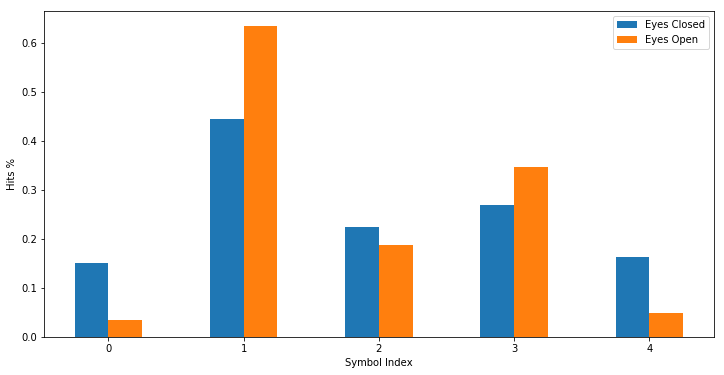

In [16]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 6))

ind = np.arange(mdl.n_protos)
p1 = ax.bar(ind - 0.125, h_grp_dist_ec[0], 0.25, label='Eyes Closed')
p2 = ax.bar(ind + 0.125, h_grp_dist_eo[0], 0.25, label='Eyes Open')

ax.legend()
ax.set_xlabel('Symbol Index')
ax.set_ylabel('Hits %')
ax.set_xticks(np.arange(mdl.n_protos))
plt.show()

Convert state prototypes to symmetric matrices and plot them

In [17]:
protos_mtx = np.zeros((mdl.n_protos, 64, 64))

for i in range(mdl.n_protos):
    symbol_state = np.zeros((64, 64))
    symbol_state[triu_ind] = mdl.protos[i, :]
    symbol_state = symbol_state + symbol_state.T
    np.fill_diagonal(symbol_state, 1.0)
    
    protos_mtx[i, :, :] = symbol_state

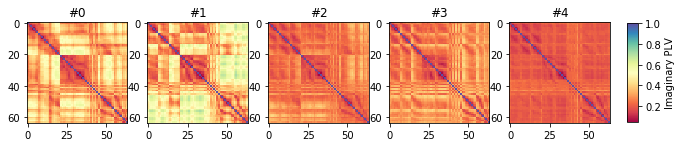

In [18]:
mtx_min = np.min(protos_mtx)
mtx_max = np.max(protos_mtx)

f, ax = plt.subplots(ncols=mdl.n_protos, figsize=(12, 12))
for i in range(mdl.n_protos):
    cax = ax[i].imshow(np.squeeze(protos_mtx[i,...]), vmin=mtx_min, vmax=mtx_max, cmap=plt.cm.Spectral)
    ax[i].set_title('#{0}'.format(i))

# move the colorbar to the side ;)
f.subplots_adjust(right=0.8)
cbar_ax = f.add_axes([0.82, 0.445, 0.0125, 0.115])
cb = f.colorbar(cax, cax=cbar_ax)
cb.set_label('Imaginary PLV')

#### Separate symbols per subject

Now we would like to analyze the symbols per subject, per group.


In [19]:
grp_sym_eo = np.array_split(grp_dist_eo, 10, axis=0)
grp_sym_ec = np.array_split(grp_dist_ec, 10, axis=0)

#### Examine the first subject 

In [20]:
subj1_eyes_open = grp_sym_eo[0]
subj1_eyes_closed = grp_sym_ec[0]

In [21]:
from dyfunconn.ts import markov_matrix

In [22]:
markov_matrix_eo = markov_matrix(subj1_eyes_open)
markov_matrix_ec = markov_matrix(subj1_eyes_closed)

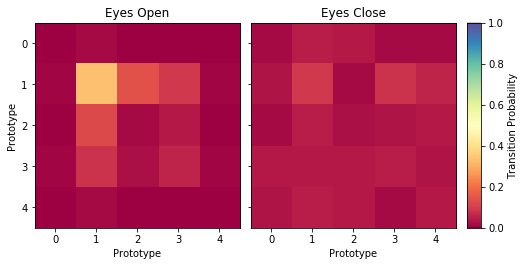

In [23]:
from mpl_toolkits.axes_grid1 import ImageGrid
f = plt.figure(figsize=(8, 6))
grid = ImageGrid(f, 111,
                 nrows_ncols=(1,2),
                 axes_pad=0.15,
                 share_all=True,
                 cbar_location="right",
                 cbar_mode="single",
                 cbar_size="7%",
                 cbar_pad=0.15,
                 )
im = grid[0].imshow(markov_matrix_eo, vmin=0.0, vmax=1.0, cmap=plt.cm.Spectral)
grid[0].set_xlabel('Prototype')
grid[0].set_ylabel('Prototype')
grid[0].set_title('Eyes Open')

im = grid[1].imshow(markov_matrix_ec, vmin=0.0, vmax=1.0, cmap=plt.cm.Spectral)
grid[1].set_xlabel('Prototype')
grid[1].set_ylabel('Prototype')
grid[1].set_title('Eyes Close')

cb = grid[1].cax.colorbar(im)
cax = grid.cbar_axes[0]
axis = cax.axis[cax.orientation]
axis.label.set_text("Transition Probability")

plt.show()

In [24]:
from dyfunconn.ts import transition_rate, occupancy_time

In [55]:
tr_eo = transition_rate(subj1_eyes_open)
tr_ec = transition_rate(subj1_eyes_closed)

print("""
Transition rate
===============
  Eyes open: {0:.3f}
Eyes closed: {1:.3f}
""".format(tr_eo, tr_ec))


Transition rate
  Eyes open: 0.580
Eyes closed: 0.765



In [61]:
occ_eo = occupancy_time(subj1_eyes_open)[0]
occ_ec = occupancy_time(subj1_eyes_closed)[0]

print("""
Occupancy time
==============
      State \t 0 \t 1 \t 2 \t 3 \t 4
      -----
  Eyes open \t {0:.3f} \t {1:.3f} \t {2:.3f} \t {3:.3f} \t {4:.3f}
Eyes closed \t {5:.3f} \t {6:.3f} \t {7:.3f} \t {8:.3f} \t {9:.3f}
""".format(*occ_eo, *occ_ec))


Occupancy time
      State 	 0 	 1 	 2 	 3 	 4
      -----
  Eyes open 	 0.000 	 0.336 	 0.017 	 0.059 	 0.000
Eyes closed 	 0.017 	 0.092 	 0.025 	 0.050 	 0.042

